Generative Adversarial Networks (GANs)
======
This code implements a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder.

In [5]:
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

Parameter Settings
-------------------


In [6]:
latent_dims = 10
num_epochs = 20
batch_size = 128
learning_rate = 2e-4
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We scale to 64x64 so we can have a deeper architecture with more down-sampling steps. The images are normalized and centerd around 0, which gives a slight performance boost during training. We create both a training set and a test set.

In [7]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Autoencoder Definition
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [8]:
class Generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x
    

def gan_loss():
    pass
    
generator = Generator()
discriminator = Discriminator()
if use_gpu:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 12656257 and discriminator: 11033985


Train GAN
--------


In [9]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = Variable(image_batch)
        label_real = Variable(torch.ones(image_batch.size(0)))
        label_fake = Variable(torch.zeros(image_batch.size(0)))
        if use_gpu:
            image_batch = image_batch.cuda()
            label_real = label_real.cuda()
            label_fake = label_fake.cuda()

        # generate image from sample of the latent prior
        latent = Variable(torch.randn(image_batch.size(0), 100, 1, 1))
        if use_gpu:
            latent = latent.cuda()
        fake_image_batch = generator(latent)
        
        # train discriminator to correctly classify real and fake
        # (creating a new variable for the fake_image_batch detaches
        # the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(Variable(fake_image_batch.data)).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.data[0]
        disc_loss_avg[-1] += disc_loss.data[0]
        num_batches += 1
        
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Training ...
Epoch [1 / 20] average loss generator vs. discrim.: 3.020292 vs. 0.409619
Epoch [2 / 20] average loss generator vs. discrim.: 1.735034 vs. 0.475215
Epoch [3 / 20] average loss generator vs. discrim.: 2.412158 vs. 0.403791
Epoch [4 / 20] average loss generator vs. discrim.: 2.866170 vs. 0.342960
Epoch [5 / 20] average loss generator vs. discrim.: 3.250457 vs. 0.277731
Epoch [6 / 20] average loss generator vs. discrim.: 3.244748 vs. 0.296331
Epoch [7 / 20] average loss generator vs. discrim.: 3.681246 vs. 0.227610
Epoch [8 / 20] average loss generator vs. discrim.: 3.921919 vs. 0.194577
Epoch [9 / 20] average loss generator vs. discrim.: 3.526002 vs. 0.264070
Epoch [10 / 20] average loss generator vs. discrim.: 3.330643 vs. 0.297252
Epoch [11 / 20] average loss generator vs. discrim.: 3.973463 vs. 0.177290
Epoch [12 / 20] average loss generator vs. discrim.: 4.465390 vs. 0.187666
Epoch [13 / 20] average loss generator vs. discrim.: 3.557203 vs. 0.252899
Epoch [14 / 20] avera

Plot Training Curves
--------------------

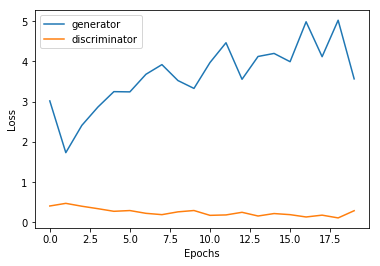

In [13]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Alternatively: Load Pre-Trained GAN
-----------------------------

In [15]:
generator.load_state_dict(torch.load('./pretrained/dcgan.pth'))
discriminator.load_state_dict(torch.load('./pretrained/dcgan_discriminator.pth'))

# this is how the GAN parameters can be saved:
# torch.save(generator.state_dict(), './pretrained/my_dcgan.pth')
# torch.save(discriminator.state_dict(), './pretrained/my_dcgan_discriminator.pth')

Interpolate in Latent Space
----------------------------

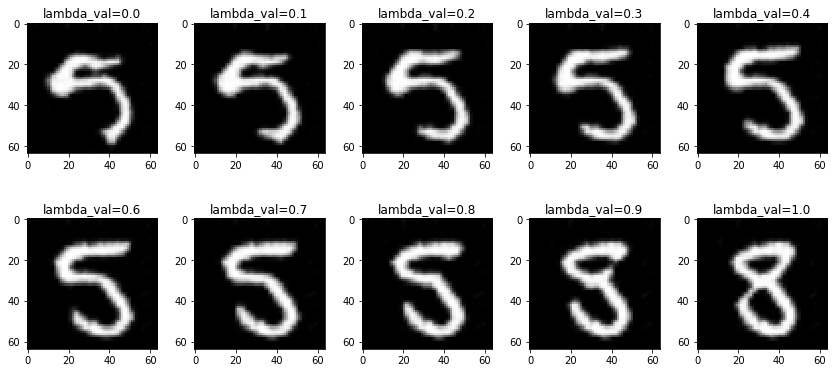

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    # interpolation of the two latent vectors
    inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2
    
    # reconstruct interpolated image
    if use_gpu:
        inter_latent = inter_latent.cuda()
    inter_image = model(inter_latent)
    if use_gpu:
        inter_image = inter_image.cpu()
    
    return inter_image
    
# sample two latent vectors from the standard normal distribution
latent_1 = Variable(torch.randn(1, 100, 1, 1))
latent_2 = Variable(torch.randn(1, 100, 1, 1))

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.data.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

Random Latent Vector (Autoencoder as Generator)
-------------------------------------------------

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution (see tutorial slides). However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

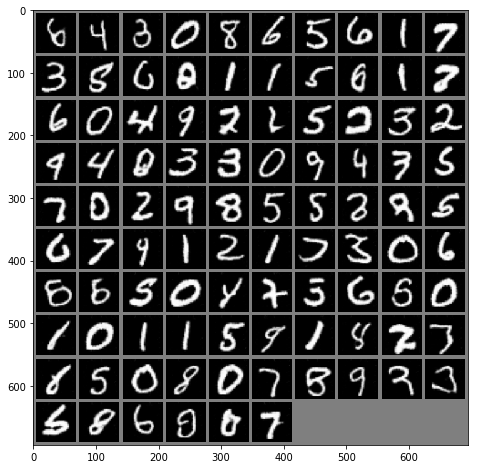

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# sample latent vectors from the standard normal distribution
latent = Variable(torch.randn(image_batch.size(0), 100, 1, 1))
if use_gpu:
    latent = latent.cuda()
fake_image_batch = generator(latent)
if use_gpu:
    fake_image_batch = fake_image_batch.cpu()

fig, ax = plt.subplots(figsize=(8, 8))
show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
plt.show()